# Q1: Scalar Computation Graph and Gradient

## TODO

In [0]:
import math
def g_w1(x1: float, x2: float, w1: float, w2: float) -> float:
    g = x1 * math.exp(-(w1 * x1 + w2 * x2)) / ((1 + math.exp(-(w1 * x1 + w2 * x2))) ** 2) + w1
    return g

def g_w2(x1: float, x2: float, w1: float, w2: float) -> float:
    g = x2 * math.exp(-(w1 * x1 + w2 * x2)) / ((1 + math.exp(-(w1 * x1 + w2 * x2))) ** 2) + w2
    return g

def g_x1(x1: float, x2: float, w1: float, w2: float) -> float:
    g = w1 * math.exp(-(w1 * x1 + w2 * x2)) / ((1 + math.exp(-(w1 * x1 + w2 * x2))) ** 2)
    return g

def g_x2(x1: float, x2: float, w1: float, w2: float) -> float:
    g = w2 * math.exp(-(w1 * x1 + w2 * x2)) / ((1 + math.exp(-(w1 * x1 + w2 * x2))) ** 2)
    return g

In [0]:
x1 = 0.2
x2 = 0.4
w1 = 0.3
w2 = -0.5

grads_x1 = []
grads_x2 = []
grads_w1 = []
grads_w2 = []
w1s = [w1]
w2s = [w2]

for i in range(30):
    grad_w1 = g_w1(x1, x2, w1, w2)    
    grad_w2 = g_w2(x1, x2, w1, w2)
    
    w2 += -0.01 * grad_w2
    w1 += -0.01 * grad_w1
    
    w1s.append(w1)
    w2s.append(w2)

    grads_w1.append(grad_w1)
    grads_w2.append(grad_w2)

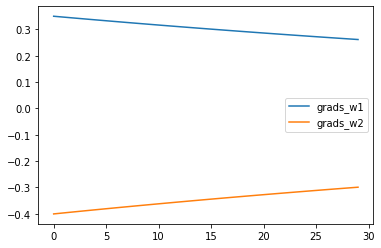

In [0]:
import matplotlib.pyplot as plt
t = range(30)
plt.plot(t, grads_w1, label = 'grads_w1')
plt.plot(t, grads_w2, label = 'grads_w2')
plt.legend()

# Q3: Neural Network From Scratch

In this section, we will implement a neural network to solve MNIST, a hand-written digits (0-9) classification dataset.

## Set up

In [0]:
import numpy as np
import matplotlib.pyplot as plt

from typing import Dict
from functools import partial

from tqdm import tqdm
tqdm.monitor_interval = 0
tqdm = partial(tqdm, bar_format='{l_bar}{r_bar}')

import torch
import torch.nn.functional as F
import torchvision

In [0]:
TRAIN_SIZE = 50_000

train = torchvision.datasets.MNIST('./data', train=True, transform=None, target_transform=None, download=True)
test = torchvision.datasets.MNIST('./data', train=False, transform=None, target_transform=None, download=True)

train_x = train.data.float().numpy()
train_y = train.targets.numpy()

shuffle_idx = np.arange(len(train_x))
np.random.RandomState(0).shuffle(shuffle_idx)
train_x = train_x[shuffle_idx]
train_y = train_y[shuffle_idx]

dev_x, dev_y = train_x[TRAIN_SIZE:], train_y[TRAIN_SIZE:]
train_x, train_y = train_x[:TRAIN_SIZE], train_y[:TRAIN_SIZE]

test_x = test.data.float().numpy()
test_y = test.targets.numpy()

Sample of images



label = 0


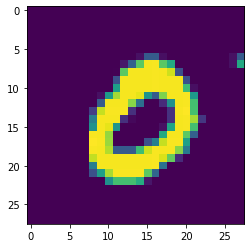

In [47]:
i = 4048 #@param {type: "slider", min: 0, max: 10000}
print(f'label = {train_y[i]}')
plt.imshow(train_x[i])
plt.show()

Each images have the same shape of 28-by-28. We flatten the matrix and pretend it is just one long vector.

In [0]:
NB_FEAT = 28 * 28

Normalize the feature. Note that we only use the training set to compute the mean and standard derivation.

In [0]:
mean = train_x.mean()
std = train_x.std()

train_x = (train_x - mean) / (std + 1e-7)
dev_x = (dev_x - mean) / (std + 1e-7)
test_x = (test_x - mean) / (std + 1e-7)

train_x = train_x.reshape(-1, NB_FEAT)
dev_x = dev_x.reshape(-1, NB_FEAT)
test_x = test_x.reshape(-1, NB_FEAT)

In [0]:
def row_logsumexp(x):
    # numerical stablization
    x_max = x.max(axis=1).reshape(-1, 1)
    return x_max + np.log(np.exp(x - x_max).sum(axis=1)).reshape(-1, 1)


In [0]:
class Parameters:
    def __init__(self):
        self.param: Dict[str, np.ndarray] = {}
        self.grad: Dict[str, np.ndarray] = {}

    def set_param(self, key: str, param: np.ndarray):
        self.param[key] = param
        self.grad[key] = np.zeros_like(param)

    def get_param(self, key):
        assert key in self.param, f'variable {key} is not part of the Parameter'
        return self.param[key]

    def accumlate_grad(self, key: str, grad: np.ndarray):
        assert key in self.param, f'variable {key} is not part of the Parameter'
        assert self.param[key].shape == grad.shape, f'for variable {key}, the shape of parameter and the shape of gradient is not matched'
        self.grad[key] += grad

    def zero_grad(self):
        for key in self.param:
            self.grad[key] = np.zeros_like(self.param[key])

    def apply_grad(self, lr: float):
        for key in self.param.keys():
            assert self.param[key].shape == self.grad[key].shape, f'for variable {key}, the shape of parameter and the shape of gradient is not matched'
            self.param[key] -= self.grad[key] * lr

In [0]:
def init_linear(input_dim, output_dim):
    return np.random.RandomState(0).randn(input_dim, output_dim) * np.sqrt(2 / input_dim)

In [0]:
def main_training(params: Parameters, forward_and_backward, train_x, train_y, dev_x, dev_y, batch_size, learning_rate, nb_epochs):
    assert isinstance(params, Parameters)
    step = 0
    best_acc = 0
    record_dev_acc = []
    for epoch in tqdm(range(nb_epochs)):
        train_loss = []
        lr = learning_rate
        for i in range(0, len(train_x), batch_size):
            batch_x = train_x[i:i+batch_size]
            batch_y = train_y[i:i+batch_size]

            loss, probs = forward_and_backward(batch_x, batch_y, params)
            params.apply_grad(lr)

            train_loss.append(loss)
            step += 1

        accs = []
        for i in range(0, len(dev_x), batch_size):
            batch_x = dev_x[i:i+batch_size]
            batch_y = dev_y[i:i+batch_size]

            loss, probs = forward_and_backward(batch_x, batch_y, params, grad=False)
            pred_y = probs.argmax(axis=1)
            accs.append(pred_y == batch_y)
        acc = np.mean(accs) * 100
        record_dev_acc.append(acc)
        print(f'epoch {epoch} train loss = {np.mean(train_loss):.3f} dev accuracy = {acc:.2f}%')
        if acc > best_acc:
            best_acc = acc

    print(f'best dev accuracy = {best_acc:.2f}%')
    return record_dev_acc

## Q2.1 Linear Classifier

Let $x \in R^{1\times N}$ be a single sample. $N$ is the number of the feature dimension and $C$ is the number of class in the final classification. Note $N=28*28$ and $C=10$

In the softmax layer, $W_{sm} \in R^{N \times C}$. The unnormalized score $s \in R^{C}$ is

$$s = x\cdot W_{sm}$$

With softmax function, we get the probability $p(c_i)$ of class $i$ where $i \in \{1,\cdots,C\}$

$$p(c_i) = \frac {\exp(s_i)} {\sum_i \exp(s_i)}$$

where $s_i$ is the $i^{th}$ element of $s$.

Assuming $y \in \{1,\cdots,C\}$, we want to minimize $-\log p(c_y)$, the cross-entropy loss between one hot true distribution `q(c_i) = 1 if i == y else 0` and $p(c_i)$.

We will take the average $-\log p(c_y)$ of a batch of x as the loss.

In `linear_classifier_forward_and_backward`, `batch_x` and `batch_y` are matrixs, where each row are $x$ and $y$, respectively.

In [0]:
linear_classifier = Parameters()
linear_classifier.set_param('w_sm', init_linear(NB_FEAT, 10))

### TODO

In [0]:
def linear_classifier_forward_and_backward(batch_x, batch_y, param: Parameters, grad=True) -> (float, np.ndarray):
    '''
    compute the loss and the gradient of each parameter
    return loss (float) and probs p(c_i) (matrix with shape batch_size x C)
    '''
    param.zero_grad()
    w_sm = param.get_param('w_sm')

    #print(batch_x.shape)
    #print(batch_y.shape)
    #print(w_sm.shape)
    # compute loss and probs
    batch_s = batch_x @ w_sm
    #probs = np.zeros((len(batch_x), 10))
    logprobs = batch_s - row_logsumexp(batch_s)
    loss = -logprobs[np.arange(len(batch_y)), batch_y].mean()
    probs = np.exp(logprobs)
    #probs = np.exp(batch_s) / np.exp(batch_s).sum(axis = 1).reshape(-1, 1)
    #loss = - np.log(probs[range(len(batch_y)),batch_y]).mean()
    #raise NotImplementedError
    #print(probs.shape)

    if not grad:
        return loss, probs

    # compute gradient
    #w_sm_grad = np.zeros_like(w_sm)
    #probs = np.exp(batch_s) / np.exp(batch_s).sum(axis = 1).reshape(-1, 1)
    probs_copy = np.copy(probs)
    probs[np.arange(len(batch_y)),batch_y] -= 1
    w_sm_grad = batch_x.T @ probs / len(batch_y)
    #print(w_sm_grad.shape)
    #raise NotImplementedError
    probs = np.copy(probs_copy)

    # save the gradient
    param.accumlate_grad('w_sm', w_sm_grad)
    return loss, probs

### Loss & Gradient Check

If all assertions are passed, it means you are good to go.

In [0]:
# use a prime number for batch size would make debugging easier
bs = 7
batch_x = train_x[:bs]
batch_y = train_y[:bs]
loss, _ = linear_classifier_forward_and_backward(batch_x, batch_y, linear_classifier)

w_sm = linear_classifier.get_param('w_sm')
_w_sm = torch.tensor(w_sm, dtype=torch.double, requires_grad=True)
_batch_x = torch.tensor(batch_x, dtype=torch.double, requires_grad=False)
_batch_y = torch.tensor(batch_y, dtype=torch.long, requires_grad=False)

_logits = F.linear(_batch_x, _w_sm.T)
_logprobs = F.log_softmax(_logits, dim=-1)
_loss = -_logprobs[torch.arange(len(_batch_y)), _batch_y].mean()
_loss.backward()

assert np.isclose(loss, _loss.item())
#print(_w_sm.grad.numpy())
#print(linear_classifier.grad['w_sm'])
assert np.allclose(_w_sm.grad.numpy(), linear_classifier.grad['w_sm'])

### Training

In [196]:
BS = 50
LR = 0.005
NB_EPOCH = 20

linear_classifier = Parameters()
linear_classifier.set_param('w_sm', init_linear(NB_FEAT, 10))

one_linear_classifier_dev_loss = main_training(linear_classifier, linear_classifier_forward_and_backward, train_x, train_y, dev_x, dev_y, BS, LR, NB_EPOCH)

  5%|| 1/20 [00:00<00:15,  1.25it/s]

epoch 0 train loss = 0.619 dev accuracy = 87.97%


 10%|| 2/20 [00:01<00:14,  1.26it/s]

epoch 1 train loss = 0.380 dev accuracy = 89.59%


 15%|| 3/20 [00:02<00:13,  1.25it/s]

epoch 2 train loss = 0.347 dev accuracy = 90.25%


 20%|| 4/20 [00:03<00:12,  1.25it/s]

epoch 3 train loss = 0.330 dev accuracy = 90.87%


 25%|| 5/20 [00:03<00:11,  1.28it/s]

epoch 4 train loss = 0.318 dev accuracy = 91.14%


 30%|| 6/20 [00:04<00:10,  1.28it/s]

epoch 5 train loss = 0.310 dev accuracy = 91.33%


 35%|| 7/20 [00:05<00:10,  1.25it/s]

epoch 6 train loss = 0.304 dev accuracy = 91.48%


 40%|| 8/20 [00:06<00:09,  1.25it/s]

epoch 7 train loss = 0.299 dev accuracy = 91.57%


 45%|| 9/20 [00:07<00:08,  1.25it/s]

epoch 8 train loss = 0.295 dev accuracy = 91.60%


 50%|| 10/20 [00:07<00:07,  1.27it/s]

epoch 9 train loss = 0.292 dev accuracy = 91.68%


 55%|| 11/20 [00:08<00:07,  1.26it/s]

epoch 10 train loss = 0.289 dev accuracy = 91.79%


 60%|| 12/20 [00:09<00:06,  1.24it/s]

epoch 11 train loss = 0.286 dev accuracy = 91.80%


 65%|| 13/20 [00:10<00:05,  1.25it/s]

epoch 12 train loss = 0.284 dev accuracy = 91.78%


 70%|| 14/20 [00:11<00:04,  1.27it/s]

epoch 13 train loss = 0.281 dev accuracy = 91.79%


 75%|| 15/20 [00:11<00:03,  1.29it/s]

epoch 14 train loss = 0.280 dev accuracy = 91.79%


 80%|| 16/20 [00:12<00:03,  1.27it/s]

epoch 15 train loss = 0.278 dev accuracy = 91.82%


 85%|| 17/20 [00:13<00:02,  1.26it/s]

epoch 16 train loss = 0.276 dev accuracy = 91.88%


 90%|| 18/20 [00:14<00:01,  1.28it/s]

epoch 17 train loss = 0.275 dev accuracy = 91.86%


 95%|| 19/20 [00:14<00:00,  1.29it/s]

epoch 18 train loss = 0.273 dev accuracy = 91.86%


100%|| 20/20 [00:15<00:00,  1.27it/s]

epoch 19 train loss = 0.272 dev accuracy = 91.93%
best dev accuracy = 91.93%


## Q2.1 MLP with Single Hidden Layer

Let $x \in R^{1\times N}$ be a single sample. $N$ is the number of the feature dimension and $C$ is the number of class in the final classification.

For the first layer, $W_1 \in R^{N\times \frac{N}{2}}$ and $b_1 \in R^{\frac{N}{2}}$

$$\bar{h}_1 = x\cdot W_1 + b_1$$

$$h_1 = ReLU(\bar{h}_1)$$

In the softmax layer, $W_{sm} \in R^{\frac{N}{2} \times C}$. The unnormalized score $s \in R^{C}$ is

$$s = h_1\cdot W_{sm}$$

With softmax function, we get the probability $p(c_i)$ of class $i$ where $i \in \{1,\cdots,C\}$

$$p(c_i) = \frac {\exp(s_i)} {\sum_i \exp(s_i)}$$

where $s_i$ is the $i^{th}$ element of $s$.

Assuming $y \in \{1,\cdots,C\}$, we want to minimize $-\log p(c_y)$, the cross-entropy loss between one hot true distribution `q(c_i) = 1 if i == y else 0` and $p(c_i)$.

We will take the average $-\log p(c_y)$ of a batch of x as the loss.

In `mlp_single_hidden_forward_and_backward`, `batch_x` and `batch_y` are matrixs, where each row are $x$ and $y$, respectively.

In [0]:
mlp_single_hidden = Parameters()
mlp_single_hidden.set_param('w1', init_linear(NB_FEAT, NB_FEAT // 2))
mlp_single_hidden.set_param('b1', np.zeros(NB_FEAT // 2))
mlp_single_hidden.set_param('w_sm', init_linear(NB_FEAT // 2, 10))

### TODO



In [0]:
def relu(x):
    return np.maximum(0, x)

def mlp_single_hidden_forward_and_backward(batch_x, batch_y, param: Parameters, grad=True):
    '''
    compute the loss and the gradient of each parameter
    return loss (float) and p(c_i) (matrix with shape batch_size x C)
    '''
    param.zero_grad()
    w1 = param.get_param('w1')
    b1 = param.get_param('b1')
    w_sm = param.get_param('w_sm')

    #print(batch_x.shape)
    #print(batch_y.shape)
    #print(w1.shape)
    #print(b1.shape)
    #print(w_sm.shape)

    # compute loss and probs
    h1_bar = batch_x @ w1 + b1.reshape(1, -1)
    h1 = relu(h1_bar)
    #print(h1.shape)
    batch_s = h1 @ w_sm
    logprobs = batch_s - row_logsumexp(batch_s)
    probs = np.exp(logprobs)
    loss = -logprobs[np.arange(len(batch_y)), batch_y].mean()
    #raise NotImplementedError

    if not grad:
        return loss, probs

    # compute gradient
    w1_grad = np.zeros_like(w1)
    b1_grad = np.zeros_like(b1)
    w_sm_grad = np.zeros_like(w_sm)
    #print(probs.shape)
    probs_copy = np.copy(probs)
    probs[np.arange(len(batch_y)),batch_y] -= 1
    probs /= len(batch_y)
    w_sm_grad = h1.T @ probs
    h1_grad = probs @ w_sm.T
    index_of_h1_bar_smaller_than_0 = np.where(h1_bar < 0)
    #print(index_of_h1_bar_smaller_than_0)
    h1_grad[index_of_h1_bar_smaller_than_0] = 0
    w1_grad = batch_x.T @ h1_grad
    b1_grad = h1_grad.sum(axis = 0)
    #raise NotImplementedError
    #print(h1_grad)
    probs = np.copy(probs_copy)

    param.accumlate_grad('w1', w1_grad)
    param.accumlate_grad('b1', b1_grad)
    param.accumlate_grad('w_sm', w_sm_grad)
    return loss, probs

### Loss & Gradient Check

If all assertions are passed, it means you are good to go.

In [0]:
# use a prime number for batch size would make debugging easier
bs = 7
batch_x = train_x[:bs]
batch_y = train_y[:bs]
loss, _ = mlp_single_hidden_forward_and_backward(batch_x, batch_y, mlp_single_hidden)

w1 = mlp_single_hidden.get_param('w1')
b1 = mlp_single_hidden.get_param('b1')
w_sm = mlp_single_hidden.get_param('w_sm')
_w1 = torch.tensor(w1, dtype=torch.double, requires_grad=True)
_b1 = torch.tensor(b1, dtype=torch.double, requires_grad=True)
_w_sm = torch.tensor(w_sm, dtype=torch.double, requires_grad=True)
_batch_x = torch.tensor(batch_x, dtype=torch.double, requires_grad=False)
_batch_y = torch.tensor(batch_y, dtype=torch.long, requires_grad=False)

_h1 = F.linear(_batch_x, _w1.T) + _b1
_h1 = F.relu(_h1)
_logits = F.linear(_h1, _w_sm.T)
_logprobs = F.log_softmax(_logits, dim=-1)
_loss = -_logprobs[torch.arange(len(_batch_y)), _batch_y].mean()
_loss.backward()

assert np.isclose(loss, _loss.item())
assert np.allclose(_w_sm.grad.numpy(), mlp_single_hidden.grad['w_sm'])
assert np.allclose(_w1.grad.numpy(), mlp_single_hidden.grad['w1'])
assert np.allclose(_b1.grad.numpy(), mlp_single_hidden.grad['b1'])

### Train!

In [200]:
BS = 50
LR = 0.005
NB_EPOCH = 20

mlp_single_hidden = Parameters()
mlp_single_hidden.set_param('w1', init_linear(NB_FEAT, NB_FEAT // 2))
mlp_single_hidden.set_param('b1', np.zeros(NB_FEAT // 2))
mlp_single_hidden.set_param('w_sm', init_linear(NB_FEAT // 2, 10))

MLP_with_single_hidden_layer_dev_loss = main_training(mlp_single_hidden, mlp_single_hidden_forward_and_backward, train_x, train_y, dev_x, dev_y, BS, LR, NB_EPOCH)

  5%|| 1/20 [00:07<02:27,  7.75s/it]

epoch 0 train loss = 0.533 dev accuracy = 90.39%


 10%|| 2/20 [00:15<02:18,  7.71s/it]

epoch 1 train loss = 0.293 dev accuracy = 92.34%


 15%|| 3/20 [00:22<02:10,  7.68s/it]

epoch 2 train loss = 0.244 dev accuracy = 93.34%


 20%|| 4/20 [00:30<02:02,  7.67s/it]

epoch 3 train loss = 0.214 dev accuracy = 94.07%


 25%|| 5/20 [00:38<01:54,  7.65s/it]

epoch 4 train loss = 0.193 dev accuracy = 94.39%


 30%|| 6/20 [00:45<01:46,  7.63s/it]

epoch 5 train loss = 0.177 dev accuracy = 94.76%


 35%|| 7/20 [00:53<01:38,  7.60s/it]

epoch 6 train loss = 0.163 dev accuracy = 95.08%


 40%|| 8/20 [01:00<01:30,  7.56s/it]

epoch 7 train loss = 0.152 dev accuracy = 95.35%


 45%|| 9/20 [01:08<01:23,  7.56s/it]

epoch 8 train loss = 0.142 dev accuracy = 95.55%


 50%|| 10/20 [01:15<01:15,  7.56s/it]

epoch 9 train loss = 0.134 dev accuracy = 95.79%


 55%|| 11/20 [01:23<01:07,  7.56s/it]

epoch 10 train loss = 0.126 dev accuracy = 95.94%


 60%|| 12/20 [01:31<01:00,  7.59s/it]

epoch 11 train loss = 0.119 dev accuracy = 96.07%


 65%|| 13/20 [01:38<00:53,  7.65s/it]

epoch 12 train loss = 0.113 dev accuracy = 96.15%


 70%|| 14/20 [01:46<00:46,  7.69s/it]

epoch 13 train loss = 0.108 dev accuracy = 96.26%


 75%|| 15/20 [01:54<00:38,  7.70s/it]

epoch 14 train loss = 0.103 dev accuracy = 96.40%


 80%|| 16/20 [02:02<00:30,  7.70s/it]

epoch 15 train loss = 0.098 dev accuracy = 96.52%


 85%|| 17/20 [02:09<00:23,  7.72s/it]

epoch 16 train loss = 0.094 dev accuracy = 96.57%


 90%|| 18/20 [02:17<00:15,  7.71s/it]

epoch 17 train loss = 0.090 dev accuracy = 96.63%


 95%|| 19/20 [02:25<00:07,  7.69s/it]

epoch 18 train loss = 0.087 dev accuracy = 96.66%


100%|| 20/20 [02:33<00:00,  7.74s/it]

epoch 19 train loss = 0.083 dev accuracy = 96.77%
best dev accuracy = 96.77%


## Q2.3 MLP with Two Hidden Layer

Let $x \in R^{1\times N}$ be a single sample. $N$ is the number of the feature dimension and $C$ is the number of class in the final classification.

For the first layer, $W_1 \in R^{N\times \frac{N}{2}}$ and $b_1 \in R^{\frac{N}{2}}$

$$\bar{h}_1 = x\cdot W_1 + b_1$$

$$h_1 = ReLU(\bar{h}_1)$$

For the second layer, $W_2 \in R^{\frac{N}{2} \times \frac{N}{2}}$ and $b_2 \in R^{\frac{N}{2}}$

$$\bar{h}_2 = h_1\cdot W_2 + b_2$$

$$h_2 = h_1 + ReLU(\bar{h}_2)$$

*Sidenote: in deep learning, $g(x, f) = x + f(x)$ is usually referred to as skip connection.*

In the softmax layer, $W_{sm} \in R^{\frac{N}{2} \times C}$. The unnormalized score $s \in R^{C}$ is

$$s = h_2\cdot W_{sm}$$

With softmax function, we get the probability $p(c_i)$ of class $i$ where $i \in \{1,\cdots,C\}$

$$p(c_i) = \frac {\exp(s_i)} {\sum_i \exp(s_i)}$$

where $s_i$ is the $i^{th}$ element of $s$.

Assuming $y \in \{1,\cdots,C\}$, we want to minimize $-\log p(c_y)$, the cross-entropy loss between one hot true distribution `q(c_i) = 1 if i == y else 0` and $p(c_i)$.

We will take the average $-\log p(c_y)$ of a batch of x as the loss.

In `mlp_two_hidden_forward_and_backward`, `batch_x` and `batch_y` are matrixs, where each row are $x$ and $y$, respectively.

In [0]:
mlp_two_hidden = Parameters()
mlp_two_hidden.set_param('w1', init_linear(NB_FEAT, NB_FEAT // 2))
mlp_two_hidden.set_param('b1', np.zeros(NB_FEAT // 2))
mlp_two_hidden.set_param('w2', init_linear(NB_FEAT // 2, NB_FEAT // 2))
mlp_two_hidden.set_param('b2', np.zeros(NB_FEAT // 2))
mlp_two_hidden.set_param('w_sm', init_linear(NB_FEAT // 2, 10))

### TODO


In [0]:
def relu(x):
    return np.maximum(0, x)

def mlp_two_hidden_forward_and_backward(batch_x, batch_y, param: Parameters, grad=True):
    '''
    compute the loss and the gradient of each parameter
    return loss (float) and p(c_i) (matrix with shape batch_size x C)
    '''
    param.zero_grad()
    w1 = param.get_param('w1')
    b1 = param.get_param('b1')
    w2 = param.get_param('w2')
    b2 = param.get_param('b2')
    w_sm = param.get_param('w_sm')

    #print(batch_x.shape)
    #print(batch_y.shape)
    #print(w1.shape)
    #print(b1.shape)
    #print(w2.shape)
    #print(b2.shape)
    #print(w_sm.shape)

    # compute loss and probs
    loss = 0
    probs = np.zeros((len(batch_x), 10))
    h1_bar = batch_x @ w1 + b1.reshape(1, -1)
    h1 = relu(h1_bar)
    h2_bar = h1 @ w2 + b2.reshape(1, -1)
    h2 = h1 + relu(h2_bar)
    #print(h1.shape)
    batch_s = h2 @ w_sm
    logprobs = batch_s - row_logsumexp(batch_s)
    probs = np.exp(logprobs)
    loss = -logprobs[np.arange(len(batch_y)), batch_y].mean()
    #raise NotImplementedError

    if not grad:
        return loss, probs

    # compute gradient
    w1_grad = np.zeros_like(w1)
    b1_grad = np.zeros_like(b1)
    w2_grad = np.zeros_like(w2)
    b2_grad = np.zeros_like(b2)
    w_sm_grad = np.zeros_like(w_sm)

    probs_copy = np.copy(probs)
    probs[np.arange(len(batch_y)),batch_y] -= 1
    probs /= len(batch_y)
    w_sm_grad = h2.T @ probs
    h2_grad = probs @ w_sm.T
    h2_bar_grad = np.copy(h2_grad)
    index_of_h2_bar_smaller_than_0 = np.where(h2_bar < 0)
    #print(index_of_h1_bar_smaller_than_0)
    h2_bar_grad[index_of_h2_bar_smaller_than_0] = 0
    w2_grad = h1.T @ h2_bar_grad
    b2_grad = h2_bar_grad.sum(axis = 0)

    h1_grad = h2_bar_grad @ w2.T + h2_grad
    index_of_h1_bar_smaller_than_0 = np.where(h1_bar < 0)
    #print(index_of_h1_bar_smaller_than_0)
    h1_grad[index_of_h1_bar_smaller_than_0] = 0
    
    w1_grad = batch_x.T @ h1_grad
    b1_grad = h1_grad.sum(axis = 0)

    probs = np.copy(probs_copy)

    param.accumlate_grad('w1', w1_grad)
    param.accumlate_grad('b1', b1_grad)
    param.accumlate_grad('w2', w2_grad)
    param.accumlate_grad('b2', b2_grad)
    param.accumlate_grad('w_sm', w_sm_grad)
    return loss, probs


### Loss & Gradient Check

If all assertions are passed, it means you are good to go.

In [0]:
# use a prime number for batch size would make debugging easier
bs = 7
batch_x = train_x[:bs]
batch_y = train_y[:bs]
loss, _ = mlp_two_hidden_forward_and_backward(batch_x, batch_y, mlp_two_hidden)

w1 = mlp_two_hidden.get_param('w1')
b1 = mlp_two_hidden.get_param('b1')
w2 = mlp_two_hidden.get_param('w2')
b2 = mlp_two_hidden.get_param('b2')
w_sm = mlp_two_hidden.get_param('w_sm')
_w1 = torch.tensor(w1, dtype=torch.double, requires_grad=True)
_b1 = torch.tensor(b1, dtype=torch.double, requires_grad=True)
_w2 = torch.tensor(w2, dtype=torch.double, requires_grad=True)
_b2 = torch.tensor(b2, dtype=torch.double, requires_grad=True)
_w_sm = torch.tensor(w_sm, dtype=torch.double, requires_grad=True)
_batch_x = torch.tensor(batch_x, dtype=torch.double, requires_grad=False)
_batch_y = torch.tensor(batch_y, dtype=torch.long, requires_grad=False)

_h1 = F.linear(_batch_x, _w1.T) + _b1
_h1 = F.relu(_h1)

_h2 = F.linear(_h1, _w2.T) + _b2
_h2 = F.relu(_h2)
_h2 = _h2 + _h1

_logits = F.linear(_h2, _w_sm.T)
_logprobs = F.log_softmax(_logits, dim=-1)
_loss = -_logprobs[torch.arange(len(_batch_y)), _batch_y].mean()
_loss.backward()

assert np.isclose(loss, _loss.item())
assert np.allclose(_w_sm.grad.numpy(), mlp_two_hidden.grad['w_sm'])
assert np.allclose(_w2.grad.numpy(), mlp_two_hidden.grad['w2'])
assert np.allclose(_b2.grad.numpy(), mlp_two_hidden.grad['b2'])
assert np.allclose(_w1.grad.numpy(), mlp_two_hidden.grad['w1'])
assert np.allclose(_b1.grad.numpy(), mlp_two_hidden.grad['b1'])

### Train!

In [204]:
BS = 50
LR = 0.005
NB_EPOCH = 20

mlp_two_hidden = Parameters()
mlp_two_hidden.set_param('w1', init_linear(NB_FEAT, NB_FEAT // 2))
mlp_two_hidden.set_param('b1', np.zeros(NB_FEAT // 2))
mlp_two_hidden.set_param('w2', init_linear(NB_FEAT // 2, NB_FEAT // 2))
mlp_two_hidden.set_param('b2', np.zeros(NB_FEAT // 2))
mlp_two_hidden.set_param('w_sm', init_linear(NB_FEAT // 2, 10))

MLP_with_2_hidden_layers_dev_acc = main_training(mlp_two_hidden, mlp_two_hidden_forward_and_backward, train_x, train_y, dev_x, dev_y, BS, LR, NB_EPOCH)

  5%|| 1/20 [00:11<03:41, 11.68s/it]

epoch 0 train loss = 0.450 dev accuracy = 91.54%


 10%|| 2/20 [00:23<03:29, 11.62s/it]

epoch 1 train loss = 0.237 dev accuracy = 93.28%


 15%|| 3/20 [00:34<03:16, 11.55s/it]

epoch 2 train loss = 0.190 dev accuracy = 94.27%


 20%|| 4/20 [00:46<03:04, 11.53s/it]

epoch 3 train loss = 0.161 dev accuracy = 94.84%


 25%|| 5/20 [00:57<02:51, 11.46s/it]

epoch 4 train loss = 0.140 dev accuracy = 95.28%


 30%|| 6/20 [01:08<02:40, 11.45s/it]

epoch 5 train loss = 0.124 dev accuracy = 95.59%


 35%|| 7/20 [01:20<02:28, 11.40s/it]

epoch 6 train loss = 0.111 dev accuracy = 95.86%


 40%|| 8/20 [01:31<02:15, 11.32s/it]

epoch 7 train loss = 0.101 dev accuracy = 96.06%


 45%|| 9/20 [01:42<02:04, 11.28s/it]

epoch 8 train loss = 0.092 dev accuracy = 96.24%


 50%|| 10/20 [01:53<01:53, 11.31s/it]

epoch 9 train loss = 0.084 dev accuracy = 96.43%


 55%|| 11/20 [02:05<01:42, 11.36s/it]

epoch 10 train loss = 0.077 dev accuracy = 96.65%


 60%|| 12/20 [02:16<01:30, 11.37s/it]

epoch 11 train loss = 0.072 dev accuracy = 96.73%


 65%|| 13/20 [02:27<01:19, 11.37s/it]

epoch 12 train loss = 0.066 dev accuracy = 96.80%


 70%|| 14/20 [02:39<01:08, 11.35s/it]

epoch 13 train loss = 0.061 dev accuracy = 96.88%


 75%|| 15/20 [02:50<00:56, 11.34s/it]

epoch 14 train loss = 0.057 dev accuracy = 96.96%


 80%|| 16/20 [03:02<00:45, 11.36s/it]

epoch 15 train loss = 0.053 dev accuracy = 97.05%


 85%|| 17/20 [03:13<00:34, 11.48s/it]

epoch 16 train loss = 0.050 dev accuracy = 97.08%


 90%|| 18/20 [03:25<00:23, 11.64s/it]

epoch 17 train loss = 0.047 dev accuracy = 97.23%


 95%|| 19/20 [03:37<00:11, 11.71s/it]

epoch 18 train loss = 0.044 dev accuracy = 97.26%


100%|| 20/20 [03:49<00:00, 11.79s/it]

epoch 19 train loss = 0.041 dev accuracy = 97.29%
best dev accuracy = 97.29%


In [207]:
BS = 100
LR = 0.01
NB_EPOCH = 20

mlp_two_hidden = Parameters()
mlp_two_hidden.set_param('w1', init_linear(NB_FEAT, NB_FEAT // 2))
mlp_two_hidden.set_param('b1', np.zeros(NB_FEAT // 2))
mlp_two_hidden.set_param('w2', init_linear(NB_FEAT // 2, NB_FEAT // 2))
mlp_two_hidden.set_param('b2', np.zeros(NB_FEAT // 2))
mlp_two_hidden.set_param('w_sm', init_linear(NB_FEAT // 2, 10))
My_train_dev_acc = main_training(mlp_two_hidden, mlp_two_hidden_forward_and_backward, train_x, train_y, dev_x, dev_y, BS, LR, NB_EPOCH)

  5%|| 1/20 [00:09<02:54,  9.19s/it]

epoch 0 train loss = 0.454 dev accuracy = 91.49%


 10%|| 2/20 [00:18<02:45,  9.17s/it]

epoch 1 train loss = 0.238 dev accuracy = 93.20%


 15%|| 3/20 [00:27<02:35,  9.14s/it]

epoch 2 train loss = 0.190 dev accuracy = 94.16%


 20%|| 4/20 [00:36<02:26,  9.18s/it]

epoch 3 train loss = 0.161 dev accuracy = 94.77%


 25%|| 5/20 [00:45<02:17,  9.17s/it]

epoch 4 train loss = 0.140 dev accuracy = 95.27%


 30%|| 6/20 [00:54<02:08,  9.15s/it]

epoch 5 train loss = 0.124 dev accuracy = 95.52%


 35%|| 7/20 [01:03<01:58,  9.13s/it]

epoch 6 train loss = 0.112 dev accuracy = 95.76%


 40%|| 8/20 [01:13<01:49,  9.12s/it]

epoch 7 train loss = 0.101 dev accuracy = 96.02%


 45%|| 9/20 [01:22<01:40,  9.13s/it]

epoch 8 train loss = 0.092 dev accuracy = 96.23%


 50%|| 10/20 [01:31<01:31,  9.15s/it]

epoch 9 train loss = 0.084 dev accuracy = 96.38%


 55%|| 11/20 [01:40<01:22,  9.15s/it]

epoch 10 train loss = 0.078 dev accuracy = 96.58%


 60%|| 12/20 [01:49<01:13,  9.14s/it]

epoch 11 train loss = 0.072 dev accuracy = 96.73%


 65%|| 13/20 [01:58<01:03,  9.11s/it]

epoch 12 train loss = 0.066 dev accuracy = 96.77%


 70%|| 14/20 [02:07<00:54,  9.10s/it]

epoch 13 train loss = 0.062 dev accuracy = 96.88%


 75%|| 15/20 [02:16<00:45,  9.07s/it]

epoch 14 train loss = 0.057 dev accuracy = 96.96%


 80%|| 16/20 [02:25<00:36,  9.06s/it]

epoch 15 train loss = 0.053 dev accuracy = 97.00%


 85%|| 17/20 [02:35<00:27,  9.10s/it]

epoch 16 train loss = 0.050 dev accuracy = 97.09%


 90%|| 18/20 [02:44<00:18,  9.10s/it]

epoch 17 train loss = 0.047 dev accuracy = 97.20%


 95%|| 19/20 [02:53<00:09,  9.10s/it]

epoch 18 train loss = 0.044 dev accuracy = 97.27%


100%|| 20/20 [03:02<00:00,  9.07s/it]

epoch 19 train loss = 0.041 dev accuracy = 97.30%
best dev accuracy = 97.30%


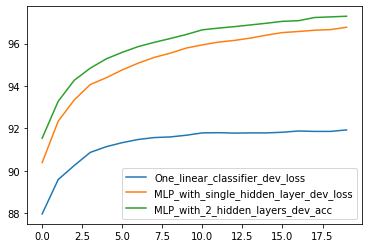

In [212]:
import matplotlib.pyplot as plt
t = range(20)
plt.plot(t, one_linear_classifier_dev_loss, label = 'One_linear_classifier_dev_loss')
plt.plot(t, MLP_with_single_hidden_layer_dev_loss, label = 'MLP_with_single_hidden_layer_dev_loss')
plt.plot(t, MLP_with_2_hidden_layers_dev_acc, label = 'MLP_with_2_hidden_layers_dev_acc')
#plt.plot(t, My_train_dev_acc, label = 'My_train_dev_acc')
plt.legend()

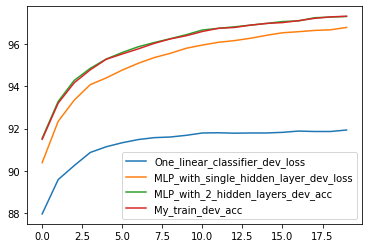

In [213]:
import matplotlib.pyplot as plt
t = range(20)
plt.plot(t, one_linear_classifier_dev_loss, label = 'One_linear_classifier_dev_loss')
plt.plot(t, MLP_with_single_hidden_layer_dev_loss, label = 'MLP_with_single_hidden_layer_dev_loss')
plt.plot(t, MLP_with_2_hidden_layers_dev_acc, label = 'MLP_with_2_hidden_layers_dev_acc')
plt.plot(t, My_train_dev_acc, label = 'My_train_dev_acc')
plt.legend()

In [211]:
test_loss, test_probs = mlp_two_hidden_forward_and_backward(test_x, test_y, mlp_two_hidden, grad = False)
pred_y = test_probs.argmax(axis = 1)
test_acc = np.mean(pred_y == test_y) * 100
print(f'The test accuracy is {test_acc:.2f}%')

The test accuracy is 97.18%
